<a href="https://colab.research.google.com/github/juangross/cursoPDI2021/blob/main/PDI_TP5_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practico TP5 (Transformada de Fourier y procesamiento espectral)
El objetivo de este TP es implementar un aplicativo que permita la generación de la Transformada de Fourier (TF) directa e Inversa de Imágenes, este debe permitir:

    Cargar una imagen
    Generar la TF directa de la imagen y ver su espectro
    A partir del espectro generado mediante la TF inversa obtener la imagen
    Debe permitir guardar el espectro de amplitud de una imagen en un bitmap
    Debe permitir cargar el espectro de imagen a partir de un bitmap

Para esto se deben hacer pruebas con diferentes figuras geométricas (Cuadrados, rectángulos, círculos, elipses, rombos, dos o más objetos, etc.) (mostrar los espectros de mínimo 5 figuras diferentes)
Adicionalmente con una imagen de su elección guardar el espectro de amplitud de la imagen en un bitmap, luego editarlo con un editor gráfico (por ejemplo, Paint), cargarlo al aplicativo y finalmente aplicar la transformada inversa (preservando la fase) para ver los efectos.
Nota: se sugiere usar los widgets tipo botón para ejecutar las operaciones mencionadas y que el aplicativo interactivo tengas todas las funciones en el mismo entorno.
Por favor revisar cuidadosamente los videos de la teoría donde se explica cuidadosamente todas las características que se desea tenga el aplicativo.

**Bloque 1** - carga de imágenes

In [9]:
#importo material de trabajo
!git clone https://github.com/juangross/cursoPDI2021



Cloning into 'cursoPDI2021'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 163 (delta 47), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (163/163), 31.46 MiB | 10.11 MiB/s, done.
Resolving deltas: 100% (47/47), done.


**Bloque 2** - Definición de funciones básicas

In [10]:
import matplotlib.pyplot as plt
import imageio as img
import numpy as np
import fnmatch
import os


#cargo imágenes de prueba
# Import an image from directory:
path="./cursoPDI2021/imagenes/"
ext="png"

def Mostrar(Img1,Txt1,Img2,Txt2,Img3,Txt3):
  plt.figure (dpi=200)
  ax1=plt.subplot(1,3,1)
  plt.imshow(Img1)
  plt.title(Txt1)
  #plt.setp(ax1.get_yticklabels(), fontsize=6)
  #plt.setp(ax1.get_xticklabels(), fontsize=6)
  plt.axis('off')

  ax2=plt.subplot(1,3,2, sharey=ax1)
  plt.imshow(Img2)
  plt.title(Txt2)
  #plt.setp(ax2.get_yticklabels(), visible=False)
  #plt.setp(ax2.get_xticklabels(), fontsize=6)
  plt.axis('off')

  ax3= plt.subplot(1,3,3, sharey=ax1)
  plt.imshow(Img3)
  plt.title(Txt3)
  #plt.setp(ax3.get_yticklabels(), visible=False)
  #plt.setp(ax3.get_xticklabels(), fontsize=6)
  plt.axis('off')
  plt.show()

#normalizar imagenes
def normImg(Img1):
  return 1/255*Img1

#transformo a 
def RGB_TO_YIQ(RGBImage ):
  #matriz de conversión de RGB -> YIQ
  RGB2YIQ=np.array([[0.299,0.587,0.114],
                    [0.595716,-0.274453,-0.321263],
                    [0.211456,-0.522591,0.311135]], dtype=float)

  #me baso en esta explicación del producto matricial para hacer la conversión de bases
  #https://stackoverflow.com/questions/46990838/numpy-transforming-rgb-image-to-yiq-color-space
  YIQ_image=np.zeros(RGBImage.shape, dtype=float)
  YIQ_image=np.dot(RGBImage,RGB2YIQ.T.copy())
  return YIQ_image

def YIQ_TO_RGB(YIQImage ):
  #matriz de conversión de RGB -> YIQ
  RGB2YIQ=np.array([[1,0.9663,0.6210],
                    [1,-0.2721,-0.6474],
                    [1,-0.1070,1.7046]], dtype=float)

  #me baso en esta explicación del producto matricial para hacer la conversión de bases
  #https://stackoverflow.com/questions/46990838/numpy-transforming-rgb-image-to-yiq-color-space
  RGB_image=np.zeros(YIQImage.shape, dtype=float)
  RGB_image=np.dot(YIQImage,RGB2YIQ.T.copy())
  return RGB_image

def sumaYIQ(Img1, Img2):
  input_tam=Img1.shape
  #Resultado=np.zeros(input_tam, dtype=float)
  yiq3=np.zeros(input_tam, dtype=float)

  #normalizo la imagen de entrada
  nImg1=1/255*Img1.astype('float') #la imagen queda en tipo float
  nImg2=1/255*Img2.astype('float') #la imagen queda en tipo float
  yiq1=RGB_TO_YIQ (nImg1)
  yiq2=RGB_TO_YIQ (nImg2)

  #sumo las imágenes con cada canal por separado
  #se interpolan los canales IQ mediante:
  #IC= (YA * IA + YB * IB) / (YA + YB)
  #QC= (YA * QA + YB * QB) / (YA + YB)
  #yiq3[:,:,0]=yiq1[:,:,0]/2+yiq2[:,:,0]/2 #suma el canal Y promediando
  #yiq3[:,:,1]=yiq1[:,:,1]+yiq2[:,:,1] 
  #yiq3[:,:,2]=yiq1[:,:,2]+yiq2[:,:,2] 
  
  yiq3[:,:,0]=yiq1[:,:,0]+yiq2[:,:,0] #luego hay que recortar
  yiq3[:,:,1]=(yiq1[:,:,0]*yiq1[:,:,1]+yiq2[:,:,0]* yiq2[:,:,1])/(yiq1[:,:,0]+yiq2[:,:,0])
  yiq3[:,:,2]=(yiq1[:,:,0]*yiq1[:,:,2]+yiq2[:,:,0]* yiq2[:,:,2])/(yiq1[:,:,0]+yiq2[:,:,0])
  #print (yiq3)

  #recorto los valores extremos y converito nuevamente a RGB
  yiq3[:,:,0]=np.clip(yiq3[:,:,0],0,1) #recorto los valores Y
  yiq3[:,:,1]=np.clip(yiq3[:,:,1],-.5957,.5957) #recorto los valores I
  yiq3[:,:,2]=np.clip(yiq3[:,:,2],-.5226,.5226) #recorto los valores Q
  Img3= YIQ_TO_RGB(yiq3)
  #print (yiq3)

  #desnormalizar
  Img3=255*Img3
  Img3=np.rint(Img3)  #redondeo a valores enteros
  Img3=np.clip(Img3,0,255) #recorto los valores que superen 255
  return Img3

  #desnormalizar
  Img3=255*Img3
  Img3=np.rint(Img3)  #redondeo a valores enteros
  Img3=np.clip(Img3,0,255) #recorto los valores que superen 255
  return Img3


#ContarValores(): cuenta valores contenidos en una lista basado en otra lista con las escalas (bins)
#Lista: lista que contiene los valores a calcular el histograma.
#Bins: lista con los rangos de valores a usar como rangos de cada Bin
#   Al hacer "lista < valor" se produce otra lista cuyo contenido es booleano
#   pero y cuyos valores True cumplen con la condición
#   el resultado de la línea completa es una máscara booleana donde aparecen valores True 
#   en las posiciones cuyos valores se encuentran dentro del rango establecido por los bins

def ContarValores(Lista, lista_Bins):
  size=len(lista_bins)
  cont = np.zeros(size)
  #cont = np.zeros(N_bins+1)
  for i in range (0, (size -1)):
#   print(np.count_nonzero(Lista>=Bins[i]) & (Lista<Bins[i+1]).sum())
    cont[i]=np.count_nonzero(Lista>=lista_bins[i]) & (Lista<lista_bins[i+1]).sum()
  return cont


#Funciones usadas para el ajuste del canal Y por coeficiente alfa y por función

#ClipYIQ(): toma una imagen en YIQ y aplica los coeficientes de recorte a los valores para mantenerlos en el rango YIQ 
def ClipYIQ(ImgYIQ):
  ImgYIQ[:,:,0]=np.clip(ImgYIQ[:,:,0],0,1) #recorto los valores Y
  ImgYIQ[:,:,1]=np.clip(ImgYIQ[:,:,1],-.5957,.5957) #recorto los valores I
  ImgYIQ[:,:,1]=np.clip(ImgYIQ[:,:,1],-.5226,.5226) #recorto los valores Q
  return ImgYIQ


#escalaYIQparte1(): realiza la conversión de RGB a YIQ 
def escalaYIQpartel(RGBImage):
  YIQimage=np.zeros(RGBImage.shape, dtype=float)

  #normalizo la imagen de entrada
  nRGBImage=1/255*RGBImage.astype('float') #la imagen queda en tipo float
  YIQimage=RGB_TO_YIQ (nRGBImage)
  return YIQimage
  

#escalaYIQparte2(): realiza la conversión de la imagen YIQ a RGB, y devuelve una imagen RGB desnormalizada lista para mostrar
def escalaYIQparte2 (YIQimage):
  #Img3= YIQ_TO_RGB(yiq3)
  RGBResultImage= YIQ_TO_RGB(YIQimage)

  #desnormalizar
  RGBResultImage=255*RGBResultImage
  RGBResultImage=np.rint(RGBResultImage)  #redondeo a valores enteros
  RGBResultImage=np.clip(RGBResultImage,0,255) #recorto los valores que superen 255
  return RGBResultImage


def ListarArchivos(path):
  from os import listdir
  from os.path import join, isfile
  
#  #listado de archivos a procesar
#  for file in os.listdir(path):
#    if fnmatch.fnmatch(file, '*.png'):
#      print (file.split(".")[:-1])
#  #print(file)
        
  lista = [".".join(f.split(".")[:-1])  for f in os.listdir(path) if f.endswith('.png')]
  return lista

def CreaDatos(path,archi,ext):
  #Lee imagen con el formato actual
  Img1=(img.imread(f"{path}{archi}.{ext}"))      #lee con imageio
  Img1=Img1.astype('float')/255 #normalizo
  Img1=np.clip(Img1,0.,1.)  #recorto los valores extremos al rango [0:1] 
  #print("leyendo archivo:", f"{path}{archi}.{ext}", Img1.shape)

  Img1_yiq=RGB_TO_YIQ(Img1)
  #print(Img1_yiq.shape)

  #FFT de la imagen original
  fimg = np.zeros(Img1_yiq[:,:,0].shape)
  fimg = np.fft.fft2(Img1_yiq[:,:,0]) #fft del canal Y de la imagen en YIQ
  fimg = np.fft.fftshift(fimg) #ajusto al centro
  #print(fimg.shape)
  #print(fimg)

  #magnitud y fase de la imagen original
  mag = np.zeros(fimg.shape)
  mag_log = np.zeros(fimg.shape)
  phase = np.zeros(fimg.shape)
  mag = np.abs(fimg)  

  # Coef BMP <- round( 32 * log( coef TF ) )
  mag_log = (np.log(mag)*32)       #ajuste propuesto por Claudio
                                  #no aplico redondeo en esta instancia
  #mag_log= mag   #bypass para pruebas
  phase = np.angle(fimg)

  #genero los archivos de magnitud y fase separados para usar en la síntesis cruzada
  np.savetxt(f"{path}{archi}.m", mag, fmt='%.4e')
  np.savetxt(f"{path}{archi}.a", phase, fmt='%.4e')
  print("datos creados:",f"{path}{archi}.m")
  print("datos creados:",f"{path}{archi}.a")

Ejecutar esto la primer vez

In [11]:
#Inicializo los datos demagnitud y fase
#cargo imágenes de prueba
path="./cursoPDI2021/imagenes/"
ext="png"

#inicializa los datos magnitud y fase para TODAS las imágenes en la lista
ListaArch=ListarArchivos(path)
#print (ListaArch)
for i in ListaArch:
  CreaDatos(path,i,ext)


datos creados: ./cursoPDI2021/imagenes/milo2r.m
datos creados: ./cursoPDI2021/imagenes/milo2r.a
datos creados: ./cursoPDI2021/imagenes/milo6r.m
datos creados: ./cursoPDI2021/imagenes/milo6r.a
datos creados: ./cursoPDI2021/imagenes/sam3r.m
datos creados: ./cursoPDI2021/imagenes/sam3r.a
datos creados: ./cursoPDI2021/imagenes/cuadrado_1p.m
datos creados: ./cursoPDI2021/imagenes/cuadrado_1p.a
datos creados: ./cursoPDI2021/imagenes/milo3r.m
datos creados: ./cursoPDI2021/imagenes/milo3r.a
datos creados: ./cursoPDI2021/imagenes/Samr.m
datos creados: ./cursoPDI2021/imagenes/Samr.a
datos creados: ./cursoPDI2021/imagenes/río_uruguay.m
datos creados: ./cursoPDI2021/imagenes/río_uruguay.a
datos creados: ./cursoPDI2021/imagenes/Sam2r.m
datos creados: ./cursoPDI2021/imagenes/Sam2r.a
datos creados: ./cursoPDI2021/imagenes/milo7r.m
datos creados: ./cursoPDI2021/imagenes/milo7r.a
datos creados: ./cursoPDI2021/imagenes/circulo_50p.m
datos creados: ./cursoPDI2021/imagenes/circulo_50p.a
datos creados: ./c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:197: RuntimeWarning: divide by zero encountered in log


datos creados: ./cursoPDI2021/imagenes/cuadrado_10x10p.m
datos creados: ./cursoPDI2021/imagenes/cuadrado_10x10p.a
datos creados: ./cursoPDI2021/imagenes/patron_RGB.m
datos creados: ./cursoPDI2021/imagenes/patron_RGB.a
datos creados: ./cursoPDI2021/imagenes/rio_uruguay_4.m
datos creados: ./cursoPDI2021/imagenes/rio_uruguay_4.a
datos creados: ./cursoPDI2021/imagenes/michar.m
datos creados: ./cursoPDI2021/imagenes/michar.a
datos creados: ./cursoPDI2021/imagenes/circulo_20p.m
datos creados: ./cursoPDI2021/imagenes/circulo_20p.a
datos creados: ./cursoPDI2021/imagenes/milo4r.m
datos creados: ./cursoPDI2021/imagenes/milo4r.a
datos creados: ./cursoPDI2021/imagenes/cuadrado_5x5p.m
datos creados: ./cursoPDI2021/imagenes/cuadrado_5x5p.a
datos creados: ./cursoPDI2021/imagenes/milo5r.m
datos creados: ./cursoPDI2021/imagenes/milo5r.a
datos creados: ./cursoPDI2021/imagenes/río_uruguay_2.m
datos creados: ./cursoPDI2021/imagenes/río_uruguay_2.a
datos creados: ./cursoPDI2021/imagenes/río_uruguay_4.m
dat

leyendo archivo: ./cursoPDI2021/imagenes/circulo_20p.png (500, 500, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part


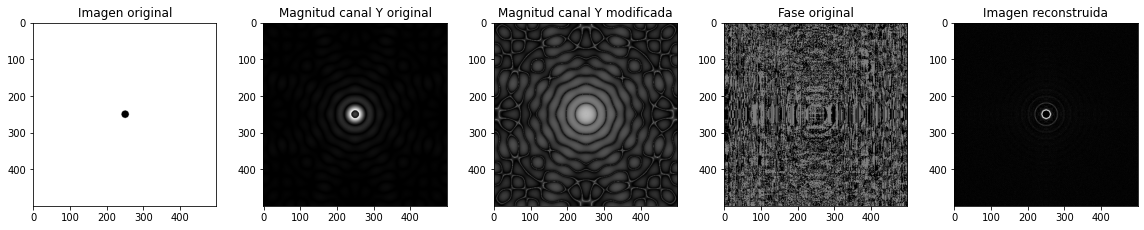

In [14]:


#cargo imágenes de prueba
# Import an image from directory:
path="./cursoPDI2021/imagenes/"
ext="png"

#Procurar buscar imágenes que tengan el mismo tamaño
archi = "circulo_20p" #@param [ "cuadrado_1p", "cuadrado_5x5p", "cuadrado_10x10p", "circulo_20p", "circulo_50p","milo5r","milo4r"]



#Lee imagen con el formato actual
Img1=(img.imread(f"{path}{archi}.{ext}"))      #lee con imageio
Img1=Img1.astype('float')/255 #normalizo
Img1=np.clip(Img1,0.,1.)  #recorto los valores extremos al rango [0:1] 
print("leyendo archivo:", f"{path}{archi}.{ext}", Img1.shape)

Img1_yiq=RGB_TO_YIQ(Img1)
#print(Img1_yiq.shape)

#FFT de la imagen original
fimg = np.zeros(Img1_yiq[:,:,0].shape)
fimg = np.fft.fft2(Img1_yiq[:,:,0]) #fft del canal Y de la imagen en YIQ
fimg = np.fft.fftshift(fimg) #ajusto al centro
#print(fimg.shape)
#print(fimg)

#magnitud y fase de la imagen original
mag = np.zeros(fimg.shape)
mag_log = np.zeros(fimg.shape)
phase = np.zeros(fimg.shape)
mag = np.abs(fimg)  

# Coef BMP <- round( 32 * log( coef TF ) )
mag_log = (np.log(mag)*32)       #ajuste propuesto por Claudio
                                #no aplico redondeo en esta instancia
#mag_log= mag   #bypass para pruebas
phase = np.angle(fimg)

#genero los archivos de magnitud y fase separados para usar en la síntesis cruzada
#np.savetxt(f"{path}{archi}_m.txt", mag, fmt='%.4e')
#np.savetxt(f"{path}{archi}_a.txt", phase, fmt='%.4e')


#reconstrucción de la imagen usando la magnitud modificada
#reconstruyo en etapas basado en magnitud y fase separadas
fimg_mod=np.zeros(fimg.shape,dtype='complex')
fimg_mod= np.cos(phase)+np.sin(phase) *1j
fimg_mod=mag_log*fimg_mod #escalo de acuerdo a la magnitud
#print(fimg_mod.shape)
#print(fimg_mod)

#inicializo el array que contiene la imagen reconstruida 
#y le precargo los canales YQ de la imagen original
#imagen reconstruida YIQ = imagen orginal con canal Y alterado, IQ originales
Img1_yiq_mod=np.zeros(Img1_yiq.shape)

Img1_yiq_mod[:,:,0]= np.fft.ifft2(np.fft.fftshift(fimg_mod)) #cargo canal Y resultado de la FFT inversa
Img1_yiq_mod[:,:,1]=Img1_yiq_mod[:,:,1]     #copio canal I original
Img1_yiq_mod[:,:,2]=Img1_yiq_mod[:,:,2]     #copio canal Q original

Img1_yiq_mod=ClipYIQ(Img1_yiq_mod)          #recorto la imagen YIQ al rango válido

Img1_mod= YIQ_TO_RGB(Img1_yiq_mod)          #convierte espacio YIQ a RGB
Img1_mod=255*Img1_mod                       #desnormalizo la imagen
Img1_mod=np.rint(Img1_mod)                  #redondeo a valores enteros
Img1_mod=np.clip(Img1_mod,0,255)            #recorto los valores que superen 255
#print(Img1_mod)

#figura base
fig, axs = plt.subplots(1, 5, tight_layout=True,figsize=(16, 16))

axs[0].imshow( Img1)
axs[0].set_title("Imagen original")

#magnitud del espectro centrado
axs[1].imshow(np.abs(fimg).astype('uint8'),cmap= 'gray')
axs[1].set_title("Magnitud canal Y original")

#axs[2].imshow(mag_log.astype('uint8'),cmap= 'gray')
#fimg_mod ya tiene aplicado el escaldo logaritmico sugerido por Claudio
axs[2].imshow(np.abs((fimg_mod)).astype('uint8'),cmap= 'gray')
axs[2].set_title("Magnitud canal Y modificada")

axs[3].imshow(phase.astype('uint8'),cmap= 'gray')
axs[3].set_title("Fase original")

axs[4].imshow( Img1_mod.astype('uint8'))
axs[4].set_title("Imagen reconstruida")
plt.show()


resultados:
**foto Milo5r:** si no se altera la magnitud Y, la imagen reconstruida pierde color . si se altera la magnitud Y utilizando el escalado propuesto por Claudio, la imagen reconstruida queda oscura, además de perder la info de color